In [62]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('default')
import seaborn as sns

In [63]:
Data_Parsing = pd.read_excel('data/Data_TSUM.xlsx', sheet_name = 'Data_Parsing')
Data_Company = pd.read_excel('data/Data_TSUM.xlsx', sheet_name = 'Data_Company')

def cleaner_df(column):
    if type(column) is not int:
        for symbol in ['_', '-', '~', '\\', '/']:
            column = column.replace(symbol, '')
    return column

for col in Data_Parsing.columns:
    Data_Parsing[col] = Data_Parsing[col].apply(cleaner_df)

display(Data_Parsing.tail())
display(Data_Company.tail())
display(Data_Parsing.info())
display(Data_Company.info())


,brand,Category,producer_id,producer_color,price
70,Stone Island,Bags,sssss111131,red,164
71,Stone Island,Bags,sssss111132,red,158
72,Stone Island,Bags,sssss111133,red,194
73,Stone Island,Bags,sssss111134,red,256
74,Stone Island,Bags,sssss111135,red,205


,brand,Category,item_id,color_id,current price
70,Stone Island,Bags,sssss111131,red,165
71,Stone Island,Bags,sssss111132,red,196
72,Stone Island,Bags,sssss111133,red,236
73,Stone Island,Bags,sssss111134,red,222
74,Stone Island,Bags,sssss111135,red,275


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 75 entries, 0 to 74
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   brand           75 non-null     object
 1   Category        75 non-null     object
 2   producer_id     75 non-null     object
 3   producer_color  75 non-null     object
 4   price           75 non-null     int64 
dtypes: int64(1), object(4)
memory usage: 3.1+ KB


None

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 75 entries, 0 to 74
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   brand          75 non-null     object
 1   Category       75 non-null     object
 2   item_id        75 non-null     object
 3   color_id       75 non-null     object
 4   current price  75 non-null     int64 
dtypes: int64(1), object(4)
memory usage: 3.1+ KB


None

In [64]:

Data_Company  = Data_Company.rename(columns = {'item_id': 'producer_id', 'color_id': 'producer_color'})
display(Data_Company.head())
total_df = Data_Parsing.merge(
    Data_Company, 
    how = 'left',
)
display(total_df.head())

,brand,Category,producer_id,producer_color,current price
0,Valentino,Shoes,aaaaa111111,black,247
1,Valentino,Shoes,aaaaa111112,black,161
2,Valentino,Shoes,aaaaa111113,black,234
3,Valentino,Shoes,aaaaa111114,black,167
4,Valentino,Shoes,aaaaa111115,black,153


,brand,Category,producer_id,producer_color,price,current price
0,Valentino,Shoes,aaaaa111111,black,167,247
1,Valentino,Shoes,aaaaa111112,black,188,161
2,Valentino,Shoes,aaaaa111113,black,184,234
3,Valentino,Shoes,aaaaa111114,black,196,167
4,Valentino,Shoes,aaaaa111115,black,250,153


In [65]:
# Подтянуть к базе парсинга данные из базы компании (item_id, color_id, current_price) 
# и сформировать столбец разницы цен в % (цена конкурента к нашей цене).
total_df['difference_price, %'] = (total_df['current price'] - total_df['price']) / total_df['price'] * 100
total_df.head()

,brand,Category,producer_id,producer_color,price,current price,"difference_price, %"
0,Valentino,Shoes,aaaaa111111,black,167,247,47.904192
1,Valentino,Shoes,aaaaa111112,black,188,161,-14.361702
2,Valentino,Shoes,aaaaa111113,black,184,234,27.173913
3,Valentino,Shoes,aaaaa111114,black,196,167,-14.795918
4,Valentino,Shoes,aaaaa111115,black,250,153,-38.800000


5.2118424461138355
0


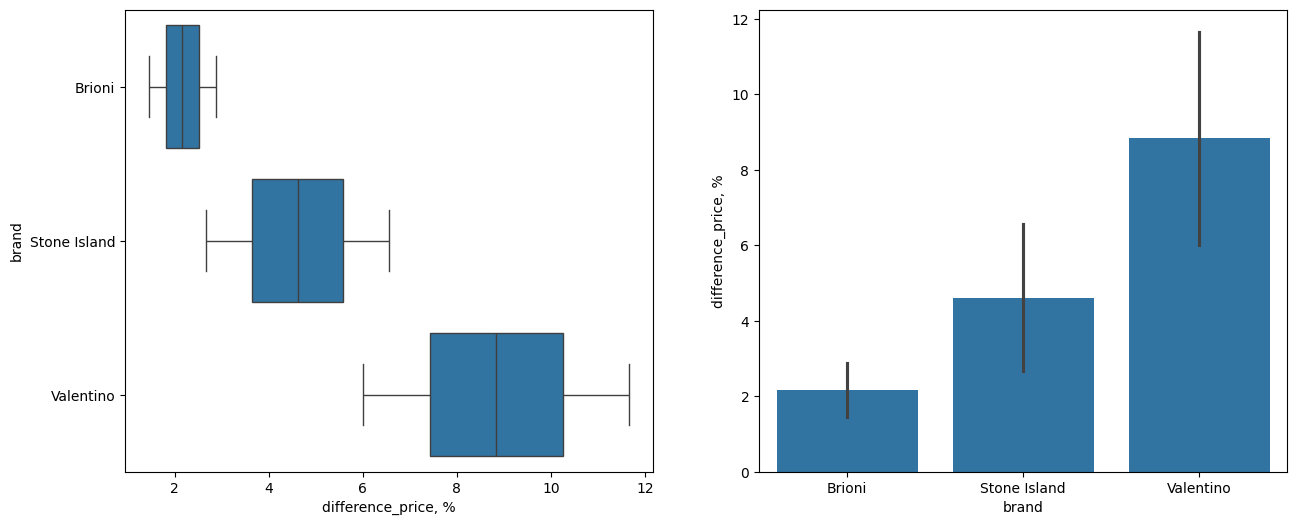

In [71]:
# Определить сильные отклонения от среднего в разности цен в пределах бренда-категории 
# (то есть убрать случайные выбросы, сильно искажающие сравнение). 
# Критерий — по вкусу, написать комментарий в коде.
print(total_df['difference_price, %'].mean())
difference_df = total_df.groupby(['brand', 'Category'], as_index = False)['difference_price, %'].mean()
fig, axes = plt.subplots(nrows=1, ncols=2, figsize = (15,6))
boxplot = sns.boxplot(
    data = difference_df,
    x = 'difference_price, %',
    y = 'brand',
    orient = 'h',
    ax = axes[0]
)
barplot = sns.barplot(
    data = difference_df,
    x = 'brand',
    y = 'difference_price, %',
    ax = axes[1]
);

def outliers_iqr(data, feature):
    x = data[feature]
    quartile_1, quartile_3 = x.quantile(0.25), x.quantile(0.75),
    iqr = quartile_3 - quartile_1
    lower_bound = quartile_1 - (iqr * 1.5)
    upper_bound = quartile_3 + (iqr * 1.5)
    outliers = data[(x < lower_bound) | (x > upper_bound)]
    cleaned = data[(x >= lower_bound) & (x <= upper_bound)]
    return outliers, cleaned

outliers, cleaned = outliers_iqr(total_df, 'difference_price, %')
print(outliers.shape[0])

In [ ]:
# Записать новый файл Excel с базой парсинга, приклееными к ней столбцами из пункта 2 и с учётом пункта 3 
# (можно добавить столбец outlier и проставить Yes для выбросов).